In [1]:
import copy
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict
from scipy.signal import savgol_filter
from utils.plot_utils import set_fontsize
from utils.binning_utils import bin_dataset_switching
from utils.hdf_utils import load_measurement_data_devices_attrs
from utils.plot_utils import plot_binned_dataset_switching
from utils.binning_utils import bin_data, find_nearest_idx, combine_arrays_irregular, \
                                average_binned_data, bin_dataset_switching

In [12]:
fname = "2020_11_18.hdf"
dset_name = "1605839266 power scan J2J3 with ratio"
attr_name = 'PXIe5171 DummyFunc'

devices = ()

In [4]:
pmt_channel = 1
shutter_channel = 2

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(fname, dset_name, devices)

In [216]:
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pmt_data -= pmt_data[:,-200:].mean(axis = 1)[:, np.newaxis]
shutter_data = np.array([pxie[idx][:,shutter_channel].mean() for idx in range(1,len(pxie)+1)])
current_data = np.array([float(pxie_attrs[idx][attr_name]) for idx in range(1,len(pxie)+1)])

In [217]:
# each amp current measurement has 2000 shots, with 50 shots per spot
ncurrents = np.unique(current_data).size # number of different amp currents
nbunched = 50 # number of shots on the same spot

In [218]:
pmt_data_reshaped = pmt_data.reshape(ncurrents,2000,2500)
currents = current_data.reshape(-1,2000).mean(axis = 1).round(2)
shutter_data_reshaped = shutter_data.reshape(ncurrents,2000)

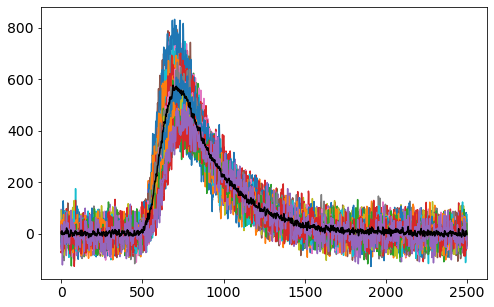

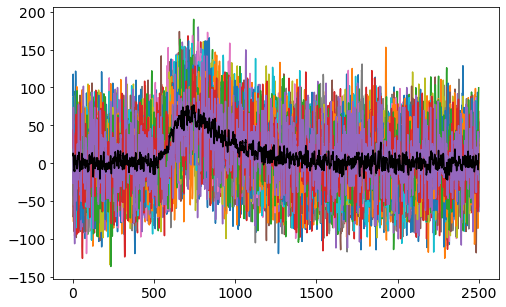

In [240]:
# taking a look at a bunch of shots
idx = 10

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(pmt_data_reshaped[0].reshape(-1,nbunched,2500)[idx][::2].T)
ax.plot(pmt_data_reshaped[0].reshape(-1,nbunched,2500)[idx][::2].mean(axis = 0), color = 'k')
set_fontsize(ax, 14)

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(pmt_data_reshaped[0].reshape(-1,nbunched,2500)[idx][1::2].T)
ax.plot(pmt_data_reshaped[0].reshape(-1,nbunched,2500)[idx][1::2].mean(axis = 0), color = 'k')
set_fontsize(ax, 14)

In [222]:
def get_shutter_slice(val):
    state = val > 2e4
    if state:
        return np.s_[::2], np.s_[1::2]
    else:
        return np.s_[1::2], np.s_[::2]

In [273]:
integral_limit = 10e3
ratios = {c:[] for c in currents}
for c,d,shut_state in zip(currents, pmt_data_reshaped, shutter_data_reshaped):
    bunched = d.reshape(-1,nbunched,2500)
    shut_bunched = shut_state.reshape(-1,nbunched)
    for st, bunch in zip(shut_bunched, bunched):
        slice_open, slice_closed = get_shutter_slice(st[0])
        mo = bunch[slice_open].mean(axis = 0)
        mc = bunch[slice_closed].mean(axis = 0)
        io = np.trapz(mo)
        ic = np.trapz(mc)
        if (io < integral_limit) or (ic < integral_limit):
            ratios[c].append(np.nan)
        else:
            ratios[c].append(io/ic)

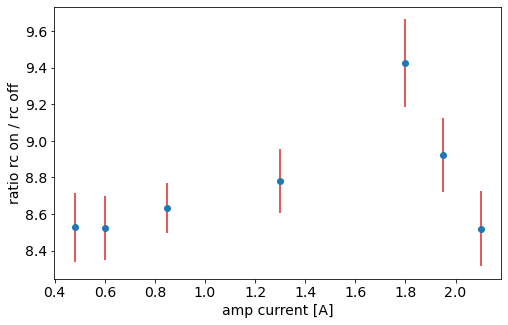

In [278]:
c = list(ratios.keys())
r = [np.nanmean(val) for val in ratios.values()]
e = [np.nanstd(val)/np.sqrt(np.sum(~np.isnan(val))) for val in ratios.values()]
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(c, r, yerr = e, fmt = '.', ms = 12, ecolor = 'C3')
ax.set_xlabel('amp current [A]')
ax.set_ylabel('ratio rc on / rc off')
set_fontsize(ax, 14)

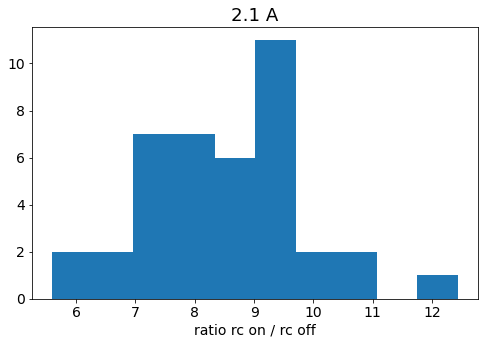

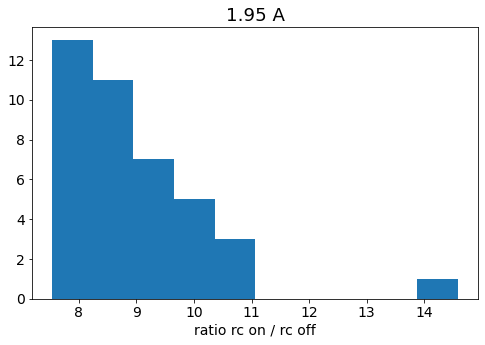

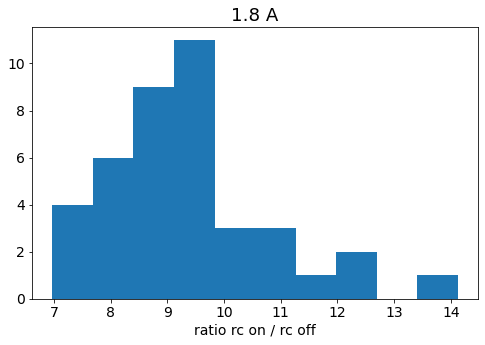

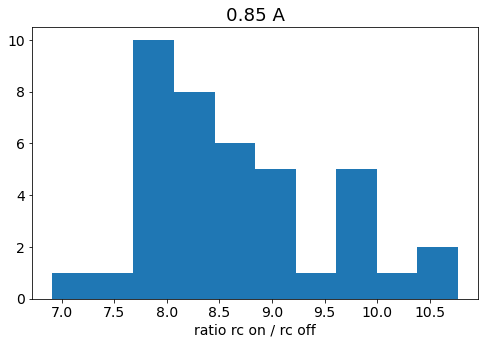

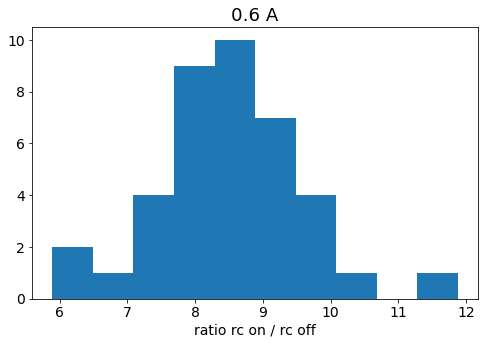

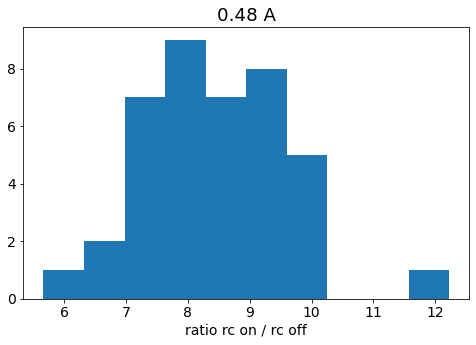

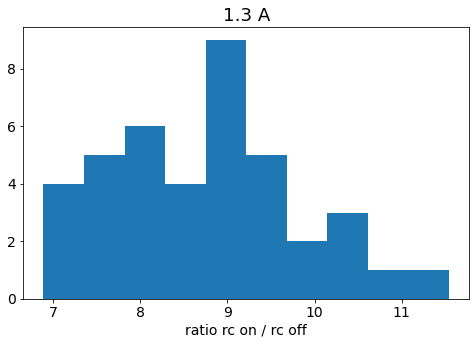

In [279]:
for key, val in ratios.items():
    fig, ax = plt.subplots(figsize = (8,5))
    ax.hist(val)
    ax.set_title(f'{key} A')
    ax.set_xlabel('ratio rc on / rc off')
    set_fontsize(ax, 14)

In [316]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    values = np.asarray(values)
    weights = np.asarray(weights)
    filter_nan = ~np.isnan(values)
    average = np.average(values[filter_nan], weights=weights[filter_nan])
    # Fast and numerically precise:
    variance = np.average((values[filter_nan]-average)**2, weights=weights[filter_nan])
    return (average, np.sqrt(variance))

In [317]:
integral_limit = 10e3
ratios = {c:[] for c in currents}
for c,d,shut_state in zip(currents, pmt_data_reshaped, shutter_data_reshaped):
    bunched = d.reshape(-1,nbunched,2500)
    shut_bunched = shut_state.reshape(-1,nbunched)
    for st, bunch in zip(shut_bunched, bunched):
        slice_open, slice_closed = get_shutter_slice(st[0])
        
        io = np.trapz(bunch[slice_open], axis = 1)
        ic = np.trapz(bunch[slice_closed], axis = 1)
        stdo = np.std(io)/np.sqrt(nbunched)
        stdc = np.std(ic)/np.sqrt(nbunched)
        
        r = io.mean()/ic.mean()
        e = r * np.sqrt((stdo/io.mean())**2 + (stdc/ic.mean())**2)
        
        if (io.mean() < integral_limit) or (ic.mean() < integral_limit):
            ratios[c].append((np.nan, np.nan))
        else:
            ratios[c].append((r.mean(), e))

In [322]:
ratio_weighted,error_weighted = [],[]
for val in ratios.values():
    r,e = zip(*val)
    e = np.array(e)
    rw,ew = weighted_avg_and_std(r,1/e**2)
    ew /= np.sqrt(50)
    ratio_weighted.append(rw)
    error_weighted.append(ew)

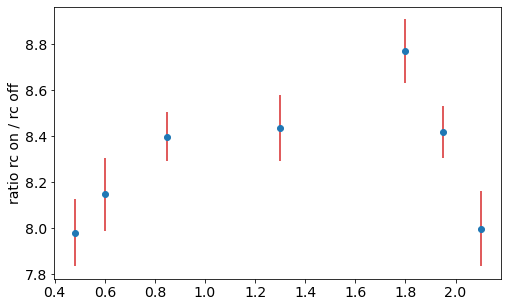

In [323]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(currents, ratio_weighted, yerr = error_weighted, fmt ='.', ecolor = 'C3', ms = 12)

ax.set_ylabel('ratio rc on / rc off')

set_fontsize(ax, 14)

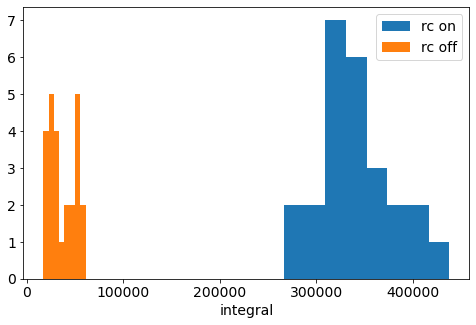

In [324]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hist(io, bins = 8, label = 'rc on')
ax.hist(ic, bins = 8, label = 'rc off')

ax.legend(fontsize = 14)

ax.set_xlabel('integral')
set_fontsize(ax, 14)

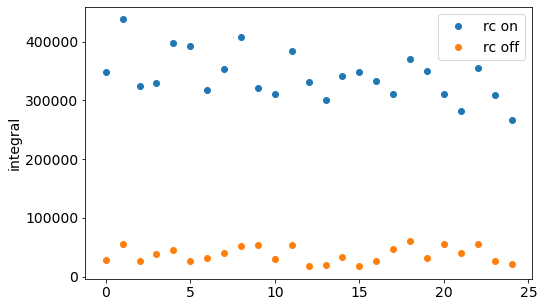

In [325]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(io, '.', label = 'rc on', ms = 12)
ax.plot(ic, '.', label = 'rc off', ms = 12)
ax.legend(fontsize = 14)
ax.set_ylabel('integral')
set_fontsize(ax, 14)

8.15 +/- 0.18


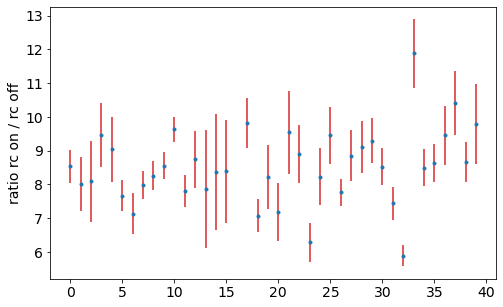

In [328]:
r,e = zip(*ratios[0.6])
r = np.array(r)
e = np.array(e)

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(x = np.arange(len(r)), y = r, yerr = e, fmt = '.', ecolor = 'C3')
ax.set_ylabel('ratio rc on / rc off')

set_fontsize(ax, 14)

rw, ew = weighted_avg_and_std(r, 1/e**2)
print(f'{rw:.2f} +/- {ew/np.sqrt(sum(~np.isnan(r))):.2f}')

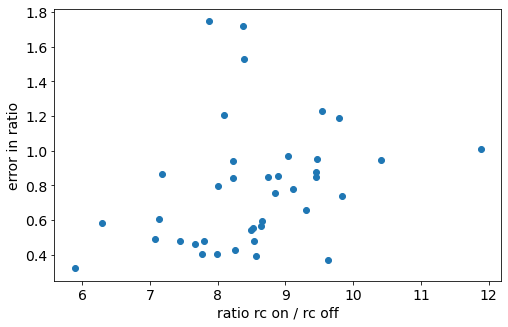

In [329]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(r, e, '.', ms = 12)

ax.set_xlabel('ratio rc on / rc off')
ax.set_ylabel('error in ratio')
set_fontsize(ax, 14)

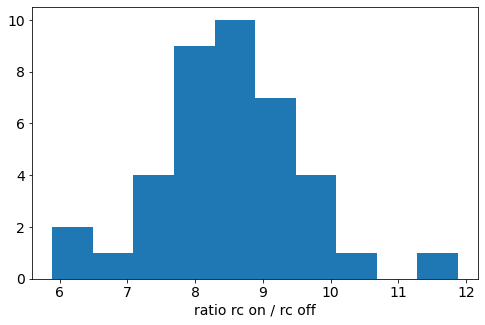

In [330]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hist(r)

ax.set_xlabel('ratio rc on / rc off')

set_fontsize(ax, 14)